# 특징 디스크립터 검출기
 - match()
 - knnMatch()
 - radiusMatch()

#### 라이브러리

In [3]:
# installs
#!pip install pytesseract
#!pip install pafy
#!pip install youtube_dl

# Data handling
import numpy as np

# Pytorch
import torch


# OpenCV, OCR
import cv2
import pytesseract
from skimage.transform import resize


# Youtube video
import pafy
import cv2


# Visualizatipn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False)

# time
from time import time

#### 차량 진입 사진 로드

In [4]:
def imread(filename, flags=cv2.IMREAD_COLOR, dtype=np.uint8):
    try:
        n = np.fromfile(filename, dtype) 
        img = cv2.imdecode(n, flags) 
        return img 
    except Exception as e: 
        print(e) 
        return None

In [5]:
greencar01 = imread('./car_image/그린카진입01.jpg')
greencar02 = imread('./car_image/그린카진입02.jpg')
socar01 = imread('./car_image/쏘카진입01.jpg')
socar02 = imread('./car_image/쏘카진입02.jpg')

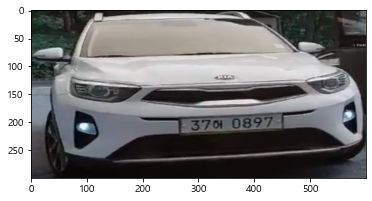

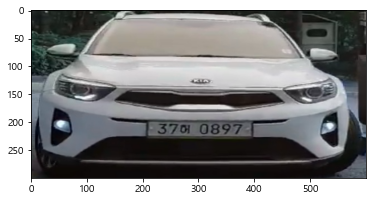

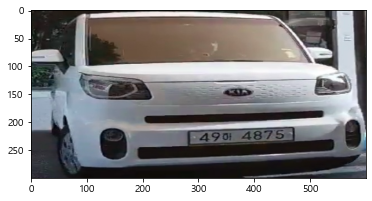

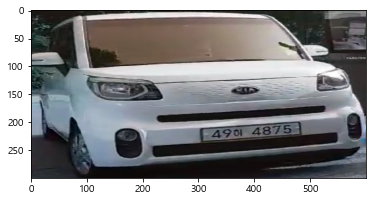

In [6]:
plt.imshow(greencar01); plt.show()
plt.imshow(greencar02); plt.show()
plt.imshow(socar01); plt.show()
plt.imshow(socar02); plt.show()


In [7]:
car_images = [greencar01, greencar02, socar01, socar02]

#### match

match() 함수는 모든 디스크립터를 하나하나 비교하여 매칭점을 찾습니다. 따라서 가장 작은 거리 값과 큰 거리 값의 상위 몇 퍼센트만 골라서 올바른 매칭점을 찾을 수 있습니다.  

아래는 match() 함수를 통해 올바른 매칭점을 찾는 코드입니다. ORB로 디스크립터를 추출하고 BF-Hamming 매칭기로 매칭을 계산했습니다. 매칭 결과의 거리(distance)를 기준으로 정렬하고 거리가 짧은 20%의 매칭점만 골랐습니다.

matches:64/253, min:12.00, max:85.00, thresh:26.60


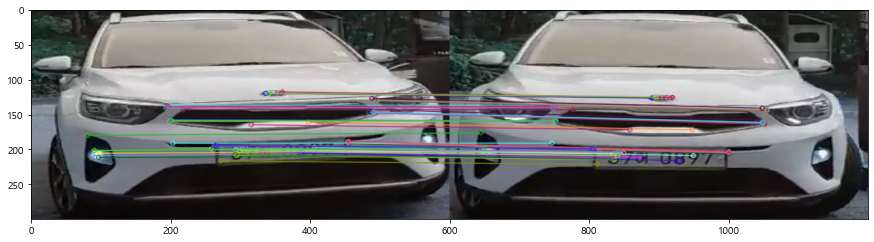

In [12]:
img1 = greencar01
img2 = greencar02
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# ORB로 서술자 추출 ---①
detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)
# BF-Hamming으로 매칭 ---②
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(desc1, desc2)

# 매칭 결과를 거리기준 오름차순으로 정렬 ---③
matches = sorted(matches, key=lambda x:x.distance)
# 최소 거리 값과 최대 거리 값 확보 ---④
min_dist, max_dist = matches[0].distance, matches[-1].distance
# 최소 거리의 15% 지점을 임계점으로 설정 ---⑤
ratio = 0.2
good_thresh = (max_dist - min_dist) * ratio + min_dist
# 임계점 보다 작은 매칭점만 좋은 매칭점으로 분류 ---⑥
good_matches = [m for m in matches if m.distance < good_thresh]
print('matches:%d/%d, min:%.2f, max:%.2f, thresh:%.2f' \
        %(len(good_matches),len(matches), min_dist, max_dist, good_thresh))
# 좋은 매칭점만 그리기 ---⑦
res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, \
                flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# 결과 출력
plt.figure(figsize=(15, 10))
plt.imshow(res)
plt.show()

matches:20/216, min:28.00, max:87.00, thresh:39.80


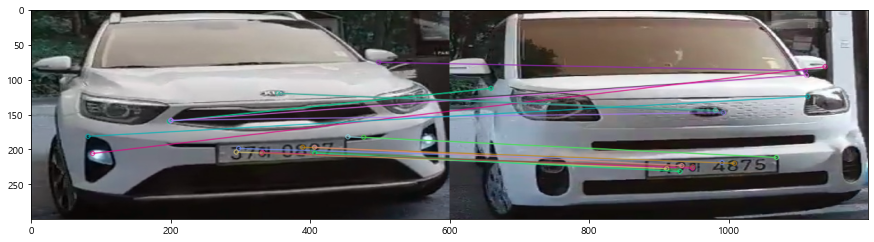

In [14]:
img1 = greencar01
img2 = socar01
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# ORB로 서술자 추출 ---①
detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)
# BF-Hamming으로 매칭 ---②
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(desc1, desc2)

# 매칭 결과를 거리기준 오름차순으로 정렬 ---③
matches = sorted(matches, key=lambda x:x.distance)
# 최소 거리 값과 최대 거리 값 확보 ---④
min_dist, max_dist = matches[0].distance, matches[-1].distance
# 최소 거리의 15% 지점을 임계점으로 설정 ---⑤
ratio = 0.2
good_thresh = (max_dist - min_dist) * ratio + min_dist
# 임계점 보다 작은 매칭점만 좋은 매칭점으로 분류 ---⑥
good_matches = [m for m in matches if m.distance < good_thresh]
print('matches:%d/%d, min:%.2f, max:%.2f, thresh:%.2f' \
        %(len(good_matches),len(matches), min_dist, max_dist, good_thresh))
# 좋은 매칭점만 그리기 ---⑦
res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, \
                flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# 결과 출력
plt.figure(figsize=(15, 10))
plt.imshow(res)
plt.show()

#### knnMatch
 knnMatch() 함수는 디스크립터당 k개의 최근접 이웃 매칭점을 가까운 순서대로 반환합니다. k개의 최근접 이웃 중 거리가 가까운 것은 좋은 매칭점이고, 거리가 먼 것은 좋지 않은 매칭점일 가능성이 높습니다. 최근접 이웃 중 거리가 가까운 것 위주로 골라내면 좋은 매칭점을 찾아낼 수 있습니다.

matches:102/486


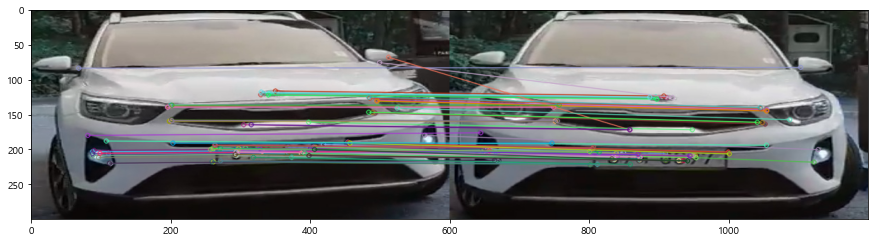

In [15]:
img1 = greencar01
img2 = greencar02
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# ORB로 서술자 추출 ---①
detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)
# BF-Hamming 생성 ---②
matcher = cv2.BFMatcher(cv2.NORM_HAMMING2)
# knnMatch, k=2 ---③
matches = matcher.knnMatch(desc1, desc2, 2)

# 첫번재 이웃의 거리가 두 번째 이웃 거리의 75% 이내인 것만 추출---⑤
ratio = 0.75
good_matches = [first for first,second in matches \
                    if first.distance < second.distance * ratio]
print('matches:%d/%d' %(len(good_matches),len(matches)))

# 좋은 매칭만 그리기
res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, \
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# 결과 출력
plt.figure(figsize=(15, 10))
plt.imshow(res)
plt.show()

matches:12/486


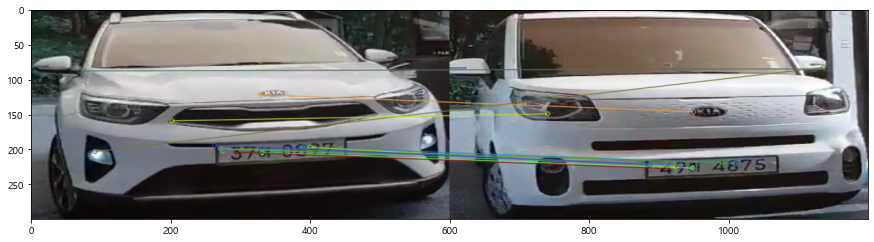

In [16]:
img1 = greencar01
img2 = socar01
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# ORB로 서술자 추출 ---①
detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)
# BF-Hamming 생성 ---②
matcher = cv2.BFMatcher(cv2.NORM_HAMMING2)
# knnMatch, k=2 ---③
matches = matcher.knnMatch(desc1, desc2, 2)

# 첫번재 이웃의 거리가 두 번째 이웃 거리의 75% 이내인 것만 추출---⑤
ratio = 0.75
good_matches = [first for first,second in matches \
                    if first.distance < second.distance * ratio]
print('matches:%d/%d' %(len(good_matches),len(matches)))

# 좋은 매칭만 그리기
res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, \
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# 결과 출력
plt.figure(figsize=(15, 10))
plt.imshow(res)
plt.show()

#### radiusMatch
올바른 매칭점을 활용해 원근 변환 행렬을 구하고, 원본 이미지 크기만큼의 사각형 도형을 원근 변환하여 결과 이미지에 표시하는 코드입니다. 이렇게 함으로써 찾고자 하는 물체가 어디 있는지 표시할 수 있습니다.

good matches:102/486


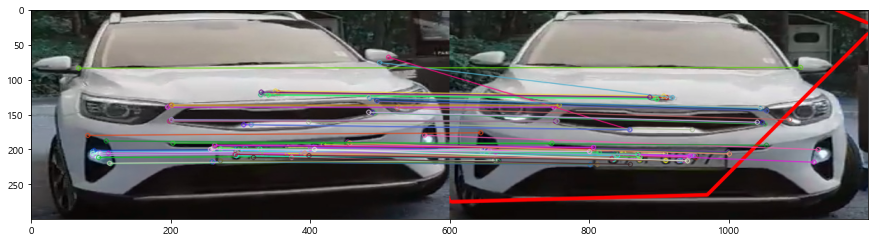

In [17]:
img1 = greencar01
img2 = greencar02
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# ORB, BF-Hamming 로 knnMatch  ---①
detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)
matcher = cv2.BFMatcher(cv2.NORM_HAMMING2)
matches = matcher.knnMatch(desc1, desc2, 2)

# 이웃 거리의 75%로 좋은 매칭점 추출---②
ratio = 0.75
good_matches = [first for first,second in matches \
                    if first.distance < second.distance * ratio]
print('good matches:%d/%d' %(len(good_matches),len(matches)))

# 좋은 매칭점의 queryIdx로 원본 영상의 좌표 구하기 ---③
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ])
# 좋은 매칭점의 trainIdx로 대상 영상의 좌표 구하기 ---④
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ])
# 원근 변환 행렬 구하기 ---⑤
mtrx, mask = cv2.findHomography(src_pts, dst_pts)
# 원본 영상 크기로 변환 영역 좌표 생성 ---⑥
h,w, = img1.shape[:2]
pts = np.float32([ [[0,0]],[[0,h-1]],[[w-1,h-1]],[[w-1,0]] ])
# 원본 영상 좌표를 원근 변환  ---⑦
dst = cv2.perspectiveTransform(pts,mtrx)
# 변환 좌표 영역을 대상 영상에 그리기 ---⑧
img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

# 좋은 매칭 그려서 출력 ---⑨
res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, \
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# 결과 출력
plt.figure(figsize=(15, 10))
plt.imshow(res)
plt.show()